In [19]:
!pip install gymnasium
!pip install renderlab
!pip install mujoco
! pip install stable_baselines3

In [20]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import SAC, TD3, A2C, PPO
import numpy as np
import matplotlib.pyplot as plt
env = gym.make('Humanoid-v4', render_mode = "rgb_array")

In [21]:
past_max_torso_position = [-9999]
step=0
past_rewards = []
past_torso_positions = []

In [22]:
def jump_reward(reward):
    global step, past_rewards, past_max_torso_position
    z_torso=env.state_vector()[0] #position of torso

    if z_torso < 0:
        salto = z_torso*5
    else:
        salto = z_torso*20

    reward=reward + salto
    past_rewards.append(reward)

    step += 1
    return reward

In [23]:
from gym import RewardWrapper
env = gym.wrappers.TransformReward(env, jump_reward)
env.reset()

(array([ 1.39620927e+00,  9.99970691e-01,  5.71564612e-03,  4.03970047e-03,
        -3.10296140e-03,  9.15286897e-03,  5.35726353e-03, -7.03418052e-03,
        -1.69256744e-03, -3.50066233e-03, -8.64179205e-03,  2.75505983e-03,
        -7.54939501e-03, -3.60128445e-03,  9.17634354e-03, -5.69835474e-04,
        -5.83099925e-03, -7.00889408e-03,  4.64979089e-04, -3.12807635e-03,
        -9.36540095e-03,  9.24026192e-03, -5.12793689e-03, -3.72050831e-03,
        -6.81917236e-03,  4.33969645e-04,  6.22954700e-04, -4.50404699e-03,
        -7.84104652e-03,  9.38118059e-03,  3.18904194e-03,  5.50473350e-03,
        -6.61141672e-04,  5.13204008e-03,  6.11198284e-03, -8.87529748e-03,
        -2.18939583e-03,  4.21167213e-03,  4.49219443e-03,  9.14263913e-03,
         6.04664095e-03, -2.93757160e-03, -8.52762877e-03, -3.64982353e-03,
        -6.80882271e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

# StableBaseline3 Models


In [24]:
model_train_SAC = SAC('MlpPolicy', env, verbose=1, device='cuda')
model_train_TD3 = TD3('MlpPolicy', env, verbose=1, device='cuda')
model__train_A2C = A2C('MlpPolicy', env, verbose=1, device='cuda')
model_train_PPO = PPO('MlpPolicy', env, verbose=1, device='cuda')

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Comparison of models in test environment

In [25]:
def test_model(env, model, video=None, msg=None):

    # Reset environment
    obs, info = env.reset()
    ep_len = 0
    ep_rew = 0

    # Run episode until complete
    while True:

        # Provide observation to policy to predict the next action
        action, _ = model.predict(obs)

        # Perform action, update total reward
        obs, reward, terminated, truncated, info = env.step(action)
        ep_rew += reward
        # Increase step counter
        ep_len += 1

        # Check to see if episode has ended
        if terminated or truncated:
            return ep_len, ep_rew

In [26]:
def learn_by_algs(alg):
      if alg == 'SAC':
          model = SAC('MlpPolicy', env, verbose=1, device='cuda')
      elif alg == 'TD3':
          model = TD3('MlpPolicy', env, verbose=1, device='cuda')
      elif alg == 'A2C':
          model = A2C('MlpPolicy', env, verbose=1, device='cuda')
      else:
          model=PPO('MlpPolicy', env, verbose=1, device='cuda')

      model.learn(total_timesteps=NUM_TRAINING_STEPS_PER_ROUND)

      # Test the model in several episodes
      tot_ep_len = 0
      tot_ep_rew = 0
      for ep in range(NUM_TESTS_PER_ROUND):
          ep_len, ep_rew = test_model(env, model)
          # Accumulate average length and reward
          tot_ep_len += ep_len
          tot_ep_rew += ep_rew
      return tot_ep_len, tot_ep_rew


In [27]:
# Training and testing hyperparameters
NUM_TRAINING_STEPS_PER_ROUND = 500
NUM_ROUNDS=20
NUM_TESTS_PER_ROUND = 1000
# Train and test the model for a number of rounds
algorithms=["SAC", "TD3", "A2C", "PPO"]
avg_ep_lens = np.zeros((4, NUM_ROUNDS))
avg_ep_rews = np.zeros((4, NUM_ROUNDS))
for rnd in range(NUM_ROUNDS):
    print(str(rnd/NUM_ROUNDS *100)+ " %")
    for i in range(4):
      # Train the model
      alg=algorithms[i]
      tot_ep_len, tot_ep_rew=learn_by_algs(alg)

      # Record and dieplay average episode length and reward
      avg_ep_len =tot_ep_len/NUM_TESTS_PER_ROUND
      avg_ep_lens[i][rnd]=avg_ep_len
      avg_ep_rew = tot_ep_rew/NUM_TESTS_PER_ROUND
      avg_ep_rews[i][rnd]=avg_ep_rew

0.0 %
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | 145      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 215      |
|    time_elapsed    | 0        |
|    total_timesteps | 109      |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 626      |
|    ent_coef        | 1        |
|    ent_coef_loss   | 0.00804  |
|    learning_rate   | 0.0003   |
|    n_updates       | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | 143      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 79       |
|    time_elapsed    | 2        |
|    total_timesteps | 220      |
| train/       

In [28]:
print(avg_ep_rews)

[[101.50493897 125.70797594 111.46835714  94.8187329  103.44319762
  101.121044    96.33626863 109.44759265 100.08116246  86.26725671
  107.59536678 101.68366842 128.46388015 109.46161897 102.14164823
  100.8711969  106.42791263 113.96661416 126.91538871  97.82861398]
 [ 92.41451007 108.00550064  60.28034191  60.90066806  75.12087137
   67.88829887  63.6396437  128.46824226 300.72601469  70.5114792
   86.3500975   96.6970665   71.90375741  87.925665    86.69814335
   91.12317965 106.97043596  73.04681399  82.02295072  76.69569575]
 [106.12951308 112.40756013 102.28399355 102.60585383 106.71562475
  109.26148899 108.51448229 110.91058832 113.74182099 107.33523779
  104.69040687 107.60073103 101.33104668 107.69036525 108.58671294
  101.13097512 112.40068211 103.4232412  104.92425814 114.10971249]
 [114.2987488  114.85653027 112.38643211 112.86677827 113.57408974
  109.89971586 110.47240726 111.05698912 114.93576606 109.31426345
  110.60245834 109.8767349  111.14021702 110.99110812 110.30

# Plot of results

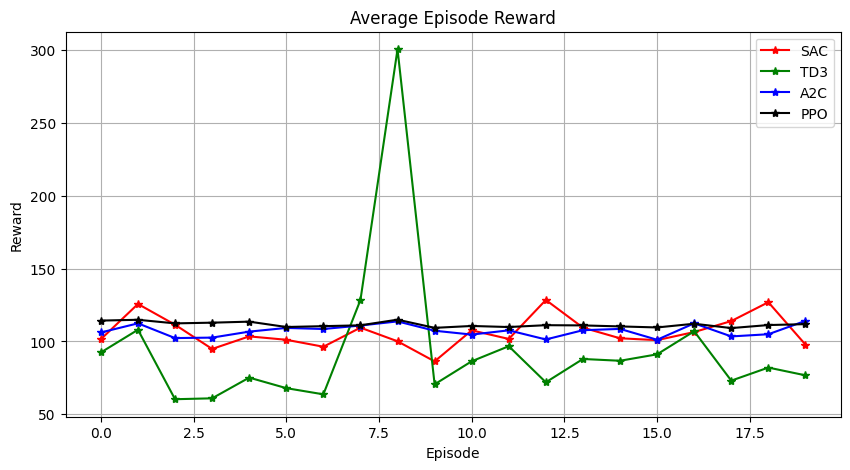

In [59]:
plt.figure(figsize=(10,5))
plt.grid(True)
color_alg=["r", "g", "b", "k"]
for i in range(4):
  '''
  plt.subplot(1,2,1)
  plt.grid(True)
  plt.title("Average Episode Length")
  plt.xlabel("Episode")
  plt.ylabel("Episode Length")
  plt.plot(range(NUM_ROUNDS),avg_ep_lens[i], marker="*", color=color_alg[i],linestyle="--", label=algorithms[i])
  plt.grid()
  plt.legend()
  plt.subplot(1,2,2)
  '''
  plt.title("Average Episode Reward")
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.plot(range(NUM_ROUNDS),avg_ep_rews[i], marker="*",color=color_alg[i],linestyle="-",label=algorithms[i])
  plt.legend()
  #plt.ylim(-300, 300)


╒═══════╤═══════════════╤══════════════════╕
│ Alg   │   Mean Reward │   Mean Ep Length │
╞═══════╪═══════════════╪══════════════════╡
│ SAC   │       186.278 │          21.3907 │
├───────┼───────────────┼──────────────────┤
│ TD3   │       174.369 │          17.1397 │
├───────┼───────────────┼──────────────────┤
│ A2C   │       187.29  │          21.8597 │
├───────┼───────────────┼──────────────────┤
│ PPO   │       191.527 │          22.562  │
╘═══════╧═══════════════╧══════════════════╛


In [54]:
avg_increase=[]
for i in range(4):
  aux=[]
  for j in range(1, NUM_ROUNDS):
    aux.append(avg_ep_rews[i][j]-avg_ep_rews[i][j-1])
  avg_increase.append(np.mean(aux))

In [58]:
regress_slope=[]
regress_inter=[]
for i in range(4):
  slope, intercept = np.polyfit(range(len(avg_ep_rews[i])), avg_ep_rews[i], 1)
  regress_slope.append(slope)
  regress_inter.append(intercept)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
from tabulate import tabulate
mean_avg_ep_rews=np.mean(avg_ep_rews, axis=1)
mean_avg_ep_lens=np.mean(avg_ep_lens, axis=1)
mean_avg_norm_ep_rews=np.mean(avg_ep_rews, axis=1)
# Crear una lista de listas para los datos de la tabla
datos_tabla = list(zip(algorithms, mean_avg_norm_ep_rews, mean_avg_ep_lens, regress_slope))

# Encabezados de la tabla
encabezados = ['Alg', 'Mean Reward', 'Mean Ep Length', "Regression Line Slope"]

# Imprimir la tabla
tabla = tabulate(datos_tabla, headers=encabezados, tablefmt='fancy_grid')

print(tabla)

╒═══════╤═══════════════╤══════════════════╤═════════════════════════╕
│ Alg   │   Mean Reward │   Mean Ep Length │   Regression Line Slope │
╞═══════╪═══════════════╪══════════════════╪═════════════════════════╡
│ SAC   │      106.278  │          21.3907 │               0.250419  │
├───────┼───────────────┼──────────────────┼─────────────────────────┤
│ TD3   │       94.3695 │          17.1397 │              -0.235873  │
├───────┼───────────────┼──────────────────┼─────────────────────────┤
│ A2C   │      107.29   │          21.8597 │               0.0199928 │
├───────┼───────────────┼──────────────────┼─────────────────────────┤
│ PPO   │      111.527  │          22.562  │              -0.16252   │
╘═══════╧═══════════════╧══════════════════╧═════════════════════════╛


Zoomed slope

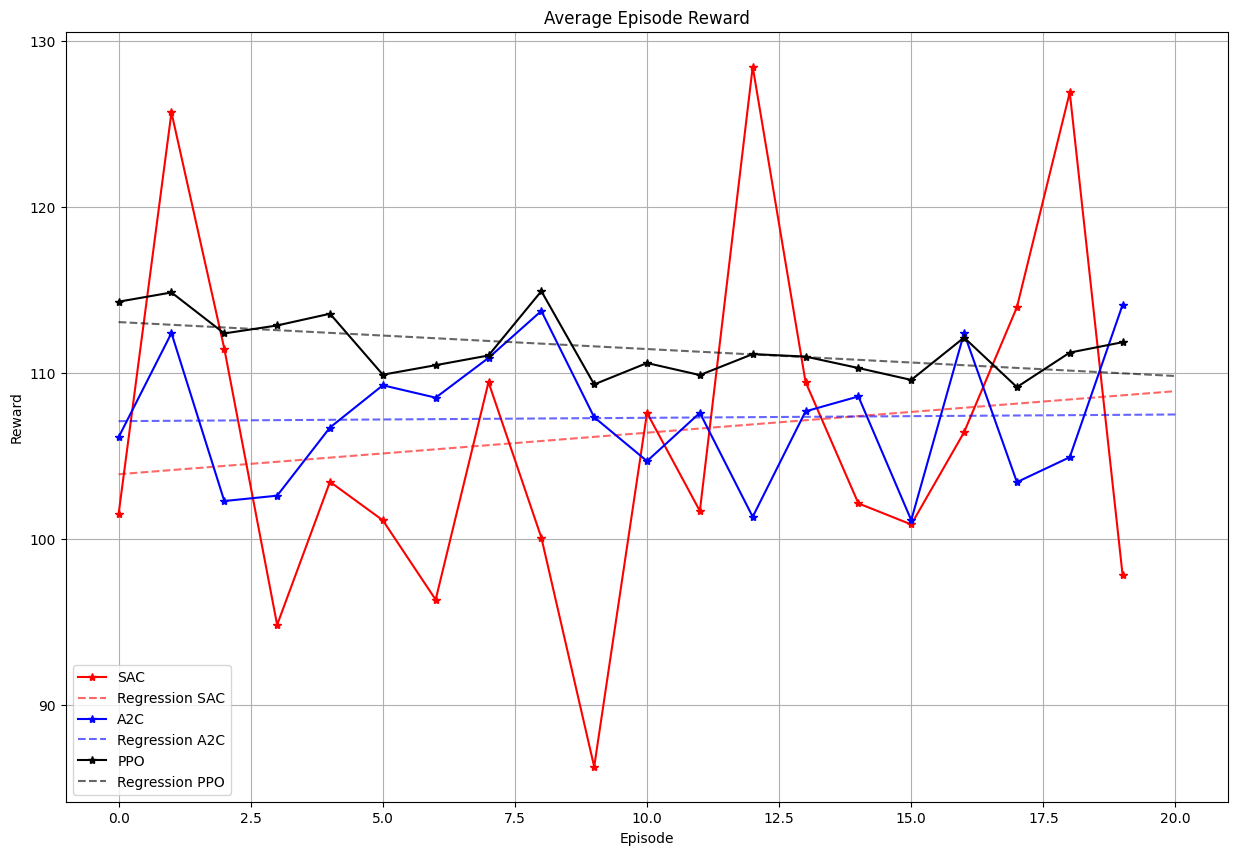

In [66]:
plt.figure(figsize=(15,10))
for i in  [0,2,3]:
  plt.title("Average Episode Reward")
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.plot(range(NUM_ROUNDS),avg_ep_rews[i], marker="*",color=color_alg[i],linestyle="-",label=algorithms[i])
  x=np.linspace(0, NUM_ROUNDS, 5000)
  plt.plot(x, regress_slope[i]*x+regress_inter[i], color=color_alg[i], linestyle="--", alpha=0.6, label=f"Regression {algorithms[i]}")
  plt.legend()
  plt.grid()
  #plt.ylim(-300, 30)